In [9]:
import pandas as pd
import joblib
import shap
import pandas as pd
import ipywidgets as widgets
from ipywidgets import VBox, Checkbox
from IPython.display import display, HTML, clear_output
import warnings
import plotly.express as px
from tqdm import tqdm
import os

In [10]:
# Make the font the same as latex 
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [11]:
# Support plotly in binder
if "BINDER_SERVICE_HOST" in os.environ:
    import plotly.io as pio
    pio.renderers.default='iframe'

In [12]:
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_csv("test_data/new leaky wave/S11_Data_combined.csv")
X = df.drop(columns=['dB(S(1,1)) []'])

In [14]:
shap.initjs()

In [15]:
X.columns

Index(['cpw_in [mm]', 'feed_l [mm]', 'patch_l [mm]', 'cpw_g [mm]',
       'Feed_W [mm]', 'ground_w [mm]', 'patch_ground_w [mm]', 'patch_w [mm]',
       'Freq [GHz]'],
      dtype='object')

In [16]:
for col in X.columns:
    print(f"{col}: Range: {X[col].min()} - {X[col].max()}, avg: {X[col].mean()}")
    print(X[col].unique().tolist())
    print('')

    # unique_vals = X[col].unique().tolist()
    # print(f"{col} & {X[col].min()} & {X[col].max()} & {abs(unique_vals[1]-unique_vals[0])} \\\\\n\\hline")

cpw_in [mm]: Range: 1.5 - 2.5, avg: 2.0
[1.5, 1.75, 2.0, 2.25, 2.5]

feed_l [mm]: Range: 3.25 - 4.25, avg: 3.75
[3.25, 3.5, 3.75, 4.0, 4.25]

patch_l [mm]: Range: 3.25 - 4.25, avg: 3.632978723404255
[3.25, 3.5, 3.75, 4.0, 4.25]

cpw_g [mm]: Range: 0.12 - 0.36, avg: 0.18893617021276599
[0.18, 0.12, 0.24, 0.3, 0.36]

Feed_W [mm]: Range: 0.5 - 2.0, avg: 1.0372340425531914
[1.0, 0.5, 0.75, 1.25, 1.5, 1.75, 2.0]

ground_w [mm]: Range: 0.5 - 1.5, avg: 1.0
[1.0, 0.5, 0.75, 1.25, 1.5]

patch_ground_w [mm]: Range: 0.5 - 1.5, avg: 1.0
[1.0, 0.5, 0.75, 1.25, 1.5]

patch_w [mm]: Range: 4.5 - 5.0, avg: 4.75
[4.75, 4.5, 5.0]

Freq [GHz]: Range: 11.0 - 20.0, avg: 15.5
[11.0, 11.09, 11.18, 11.27, 11.36, 11.45, 11.54, 11.63, 11.72, 11.81, 11.9, 11.99, 12.08, 12.17, 12.26, 12.35, 12.44, 12.53, 12.62, 12.71, 12.8, 12.89, 12.98, 13.07, 13.16, 13.25, 13.34, 13.43, 13.52, 13.61, 13.7, 13.79, 13.88, 13.97, 14.06, 14.15, 14.24, 14.33, 14.42, 14.51, 14.6, 14.69, 14.78, 14.87, 14.96, 15.05, 15.14, 15.23, 15.32,

In [17]:
complete_df = pd.DataFrame(columns=X.columns)

In [18]:
# Create all combinations of ranges 
ranges = {}
data_cols = list(X.columns)
for column in data_cols:
    ranges[column] = X[column].unique().tolist()

# Custom overrides
# ranges['inset_dist [mm]'] += [0.8, 1.2]
# ranges['L [mm]'] += [11.75, 12.25]
# ranges['W [mm]'] += [14.2, 14.4, 14.6, 15.0, 15.2, 15.4]
# ranges['W0 [mm]'] += [2.75, 3.25]
# ranges['y0 [mm]'] += [3.25, 3.75, 4.25, 4.75]

In [19]:
test = 0
for col in ranges:
    print(len(ranges[col]))

5
5
5
5
7
5
5
3
101


In [20]:
# Try cartesian product in pandas instead https://stackoverflow.com/a/13270110/3675086
ranges_df = pd.DataFrame(ranges[X.columns[0]], columns=[X.columns[0]])
for col in complete_df.columns[1:]:
    temp_df = pd.DataFrame(ranges[col], columns=[col])
    ranges_df = ranges_df.merge(temp_df, how='cross')

In [21]:
ranges_df

,cpw_in [mm],feed_l [mm],patch_l [mm],cpw_g [mm],Feed_W [mm],ground_w [mm],patch_ground_w [mm],patch_w [mm],Freq [GHz]
0,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.75,11.00
1,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.75,11.09
2,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.75,11.18
3,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.75,11.27
4,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.75,11.36
...,...,...,...,...,...,...,...,...,...
33140620,2.5,4.25,4.25,0.36,2.0,1.5,1.5,5.00,19.64
33140621,2.5,4.25,4.25,0.36,2.0,1.5,1.5,5.00,19.73
33140622,2.5,4.25,4.25,0.36,2.0,1.5,1.5,5.00,19.82
33140623,2.5,4.25,4.25,0.36,2.0,1.5,1.5,5.00,19.91


In [22]:
# Remove duplicates that are already calculated https://stackoverflow.com/a/47107164
df_all = ranges_df.merge(X.drop_duplicates(), on=X.columns.tolist(), how='left', indicator=True)
df_all = df_all[df_all['_merge'] == 'left_only']
df_all.drop(columns=['_merge'], inplace=True, axis=1)

In [23]:
# Run thru ML model to get predictions
model = joblib.load('antenna_model.pkl')
predictions = model.predict(df_all)

In [24]:
df_all['prediction'] = predictions

In [25]:
df_all.to_pickle("all_predictions.pkl")

In [26]:
df_all

,cpw_in [mm],feed_l [mm],patch_l [mm],cpw_g [mm],Feed_W [mm],ground_w [mm],patch_ground_w [mm],patch_w [mm],Freq [GHz],prediction
101,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.5,11.00,-1.523185
102,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.5,11.09,-1.560275
103,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.5,11.18,-1.639599
104,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.5,11.27,-1.734228
105,1.5,3.25,3.25,0.18,1.0,1.0,1.0,4.5,11.36,-1.865018
...,...,...,...,...,...,...,...,...,...,...
33140620,2.5,4.25,4.25,0.36,2.0,1.5,1.5,5.0,19.64,-11.530287
33140621,2.5,4.25,4.25,0.36,2.0,1.5,1.5,5.0,19.73,-12.085500
33140622,2.5,4.25,4.25,0.36,2.0,1.5,1.5,5.0,19.82,-13.711969
33140623,2.5,4.25,4.25,0.36,2.0,1.5,1.5,5.0,19.91,-17.550520


In [27]:
working_geometries = pd.DataFrame()
s11_val = 0
freq_val = 0
show_best_only = True

# Filter working_geometries by best
def filter_by_best():
    best_s11 = 0
    filtered_geometries = working_geometries.copy()
    freq_min, freq_max = freq_val
    unique_geometries = filtered_geometries['Geometry Name'].unique()
    for i, geometry_name in enumerate(unique_geometries):
        rows = filtered_geometries[filtered_geometries['Geometry Name'] == geometry_name]
        rows_in_freq = rows[(rows['Freq [GHz]'] > freq_min) & (rows['Freq [GHz]'] < freq_max)]
        if rows_in_freq['prediction'].max() > best_s11:
            filtered_geometries.drop(rows.index, inplace=True)
        elif rows_in_freq['prediction'].max() < best_s11:
            best_s11 = rows_in_freq['prediction'].max()
    return filtered_geometries

import matplotlib.pyplot as plt

out = widgets.Output()
@out.capture()
def print_dimensions():
    clear_output()

    if not working_geometries.empty:
        print("Loading...")
        filtered_geometries = working_geometries if not show_best_only else filter_by_best()

        freq_min, freq_max = freq_val
        unique_geometries = filtered_geometries['Geometry Name'].unique()
        display(HTML(f"<h2>{unique_geometries.shape[0]} Geometries</h2>"))

        unique_geometries = unique_geometries[:100]

        # Begin setting up matplotlib figure
        plt.figure(figsize=(6,4))

        # Create & display plotly figure
        fig = px.line(filtered_geometries, x="Freq [GHz]", y="prediction", title='Performance vs Frequency for Geometries', color="Geometry Name")
        fig.add_hline(y=s11_val, line_dash="dash", line_color="blue")
        fig.add_vline(x=freq_min, line_dash="dash", line_color="green")
        fig.add_vline(x=freq_max, line_dash="dash", line_color="green")
        display(fig)

        for i, geometry_name in enumerate(unique_geometries):
            rows = filtered_geometries[filtered_geometries['Geometry Name'] == geometry_name]
            columns = rows.columns
            result_line = ""
            # Print all cols except freq and prediction
            columns = [col for col in columns if col not in ["Freq [GHz]", "prediction", "Geometry Name"]]
            for column in columns:
                col = rows.iloc[0][column]
                result_line += f"<li>{column}: {round(col, 4)}</li>"

            # Print s11
            filtered_values = rows[(rows['Freq [GHz]'] > freq_min) & (rows['Freq [GHz]'] < freq_max)]
            s11_min = filtered_values['prediction'].max()
            s11_max = filtered_values['prediction'].min()
            result_line += f"<li>dB(S(1,1)): {round(s11_min, 4)} thru {round(s11_max, 4)}</li>"

            # Plot line for matplotlib 
            plt.plot(rows['Freq [GHz]'], rows['prediction'], label=geometry_name)
                    
            display(HTML(f"<h4>{geometry_name}</h4><ul>{result_line}</ul>"))

        # Finish setting up matplotlib figure 
        plt.xlabel("Freq [GHz]")
        plt.ylabel("prediction")
        legend_disp = unique_geometries[:10].tolist()
        if len(unique_geometries) > 10:
            legend_disp += ["..."]
        plt.legend(legend_disp, loc="upper left")
        plt.axhline(y=s11_val, color='b', linestyle='--')
        plt.axvline(x=freq_min, color='g', linestyle='--')
        plt.axvline(x=freq_max, color='g', linestyle='--')
        # plt.savefig(f"{'-'.join([str(geo) for geo in legend_disp])}.png")
    else:
        display(HTML("<h2>No results found</h2>"))

def print_shap(dimensions_for_prediction):
    explainer = shap.TreeExplainer(model.named_steps['model'])
    shap_values = explainer(dimensions_for_prediction)

    display(HTML("<h2>Shap Explanation</h2>"))
    shap.plots.waterfall(shap_values[0], max_display=14)

In [28]:
def print_prediction():
    global working_geometries

    freq_min, freq_max = freq_val

    geo_params = df.columns.tolist()[:-2]
    df_all['Geometry Name'] = df_all.groupby(geo_params).ngroup() # Set the name for each group of geometry 

    # Filter by only frequencies that are requested
    geometries_within_freq = df_all[(df_all['Freq [GHz]'] > freq_min) & (df_all['Freq [GHz]'] < freq_max)]
    # Get df of unique geometries within filter, keeping the freq column with the highest freq of each
    geometries_within_freq = geometries_within_freq.drop_duplicates(subset=geometries_within_freq.columns[:-1], keep='first')

    # Filter by only s11 values that are requested
    # https://stackoverflow.com/questions/55262665/finding-groups-that-meet-a-condition-in-pandas-groupby 
    # https://stackoverflow.com/questions/62713000/keep-only-groups-where-all-values-satisfy-a-condition
    print('filtering by s11')
    geometries_within_s11 = geometries_within_freq[geometries_within_freq['prediction'].lt(s11_val).groupby(geometries_within_freq['Geometry Name']).transform('all')]

    working_geometries = df_all[df_all['Geometry Name'].isin(geometries_within_s11['Geometry Name'].unique())]

    # Print results 
    print_dimensions()
    print('PRINT SHAP')
    geos_to_pass = working_geometries.copy()
    geos_to_pass.drop(columns=['Geometry Name', 'prediction'], inplace=True)
    print_shap(geos_to_pass.iloc[0]) # TODO FIX ME NOT WORKING 

In [29]:
predictions.min(), predictions.max()

(-70.14749, 14.692954)

filtering by s11


PRINT SHAP


IndexError: single positional indexer is out-of-bounds

filtering by s11


PRINT SHAP


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/shap/shap/issues/580.

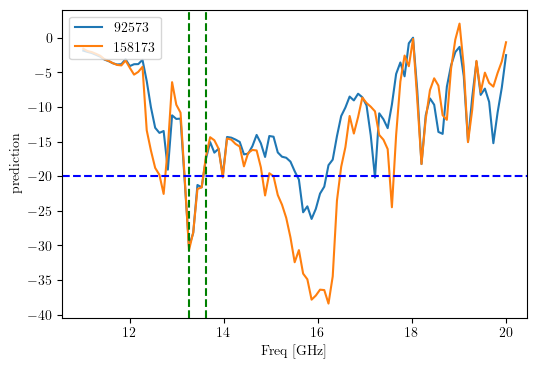

filtering by s11


PRINT SHAP


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/shap/shap/issues/580.

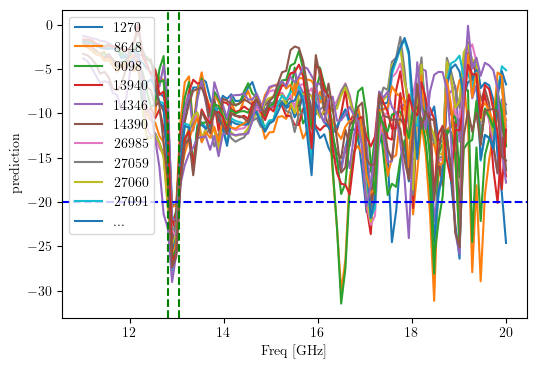

filtering by s11


PRINT SHAP


IndexError: single positional indexer is out-of-bounds

filtering by s11


PRINT SHAP


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/shap/shap/issues/580.

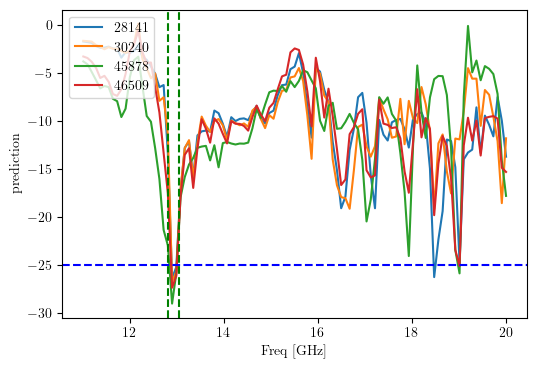

In [30]:
s11_input = widgets.BoundedFloatText(value=-10, min=predictions.min(), max=predictions.max(), step=0.05, description="S11:")
freq_input = widgets.FloatRangeSlider(min=df['Freq [GHz]'].min(), max=df['Freq [GHz]'].max(), step=0.01, description="Frequency Range:")

def on_button_clicked(b):
    global s11_val, freq_val
    s11_val = s11_input.value
    freq_val = freq_input.value
    print_prediction()

def show_best_function(checkbox_val):
    global show_best_only
    show_best_only = checkbox_val['new']
    print_dimensions()

go_button = widgets.Button(description="Run")
go_button.on_click(on_button_clicked)

show_best_checkbox = Checkbox(True, description='Only Show Best')
show_best_checkbox.observe(show_best_function, names=['value'])

In [31]:
VBox([s11_input, freq_input, go_button, show_best_checkbox, out])